## Arm Reaching (MI Session 1)

In [1]:
import os
import glob
import numpy as np
import mne
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')
from scipy.io import loadmat
from scipy.signal import butter, lfilter

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne.decoding import CSP
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### BrainVision (.vhdr, .vmrk, .eeg)

The BrainVision file format consists of three separate files:

1. A text header file (.vhdr) containing meta data.

2. A text marker file (.vmrk) containing information about events in the data.

3. A binary data file (.eeg) containing the voltage values of the EEG.

In [2]:
folder_path=r'D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI'
folder_files=os.listdir(folder_path)
for i in folder_files:
    print(i)

session1_sub10_reaching_MI.eeg
session1_sub10_reaching_MI.vhdr
session1_sub10_reaching_MI.vmrk
session1_sub1_reaching_MI.eeg
session1_sub1_reaching_MI.vhdr
session1_sub1_reaching_MI.vmrk
session1_sub2_reaching_MI.eeg
session1_sub2_reaching_MI.vhdr
session1_sub2_reaching_MI.vmrk
session1_sub3_reaching_MI.eeg
session1_sub3_reaching_MI.vhdr
session1_sub3_reaching_MI.vmrk
session1_sub4_reaching_MI.eeg
session1_sub4_reaching_MI.vhdr
session1_sub4_reaching_MI.vmrk
session1_sub5_reaching_MI.eeg
session1_sub5_reaching_MI.vhdr
session1_sub5_reaching_MI.vmrk
session1_sub6_reaching_MI.eeg
session1_sub6_reaching_MI.vhdr
session1_sub6_reaching_MI.vmrk
session1_sub7_reaching_MI.eeg
session1_sub7_reaching_MI.vhdr
session1_sub7_reaching_MI.vmrk
session1_sub8_reaching_MI.eeg
session1_sub8_reaching_MI.vhdr
session1_sub8_reaching_MI.vmrk
session1_sub9_reaching_MI.eeg
session1_sub9_reaching_MI.vhdr
session1_sub9_reaching_MI.vmrk


In [3]:
eeg,vhdr,vmrk = [],[],[]

for i in folder_files:
    file=folder_path+'\\'+i
    if '.eeg' in file:
        eeg.append(file) 
    elif '.vhdr' in file:
        vhdr.append(file) 
    else:
        vmrk.append(file)
        
for i in range(0,len(eeg)):
    print(eeg[i]+'\n'+vhdr[i]+'\n'+vmrk[i]+'\n')

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub10_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub10_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub10_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub1_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub1_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub1_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub2_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub2_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub2_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub3_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub3_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub3_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub4_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reach

### Read Raw Signals

In [4]:
raw = mne.io.read_raw_brainvision(vhdr[1], misc='auto', scale=1.0, preload=True, verbose=None)
raw # OR raw.info

Extracting parameters from D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub1_reaching_MI.vhdr...
Setting channel info structure...
Reading 0 ... 10055299  =      0.000 ...  4022.120 secs...


<RawBrainVision | session1_sub1_reaching_MI.eeg, 71 x 10055300 (4022.1 s), ~5.32 GB, data loaded>

In [5]:
raw.set_channel_types(mapping={'hEOG_L': 'eog', 'hEOG_R': 'eog', 'vEOG_U': 'eog', 'vEOG_D': 'eog'})
raw.set_channel_types(mapping={'EMG_1': 'emg', 'EMG_2': 'emg', 'EMG_3': 'emg', 'EMG_4': 'emg', 'EMG_5': 'emg', 'EMG_6': 'emg', 'EMG_ref': 'emg'})
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, AFz, F7, F5, F3, F1, Fz, FT7, FC5, FC3, FC1, T7, ...
 chs: 60 EEG, 4 EOG, 7 EMG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1250.0 Hz
 meas_date: 2019-08-22 11:48:44 UTC
 nchan: 71
 projs: []
 sfreq: 2500.0 Hz
>

In [6]:
print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print(raw.info['sfreq'], 'Hz')            # sampling frequency
print(raw.info['description'], '\n')      # miscellaneous acquisition info

bad channels: []
2500.0 Hz
None 



Using matplotlib as 2D backend.


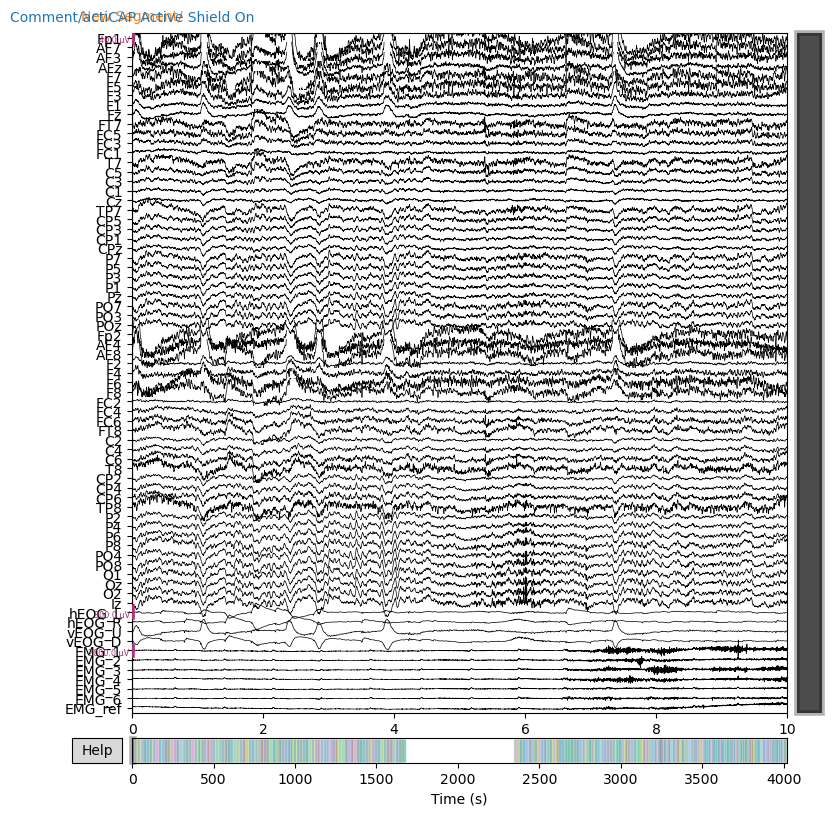

In [7]:
raw.plot(n_channels=71);

### For One Session, Each Subject Do :
 - 50 Trials For Each Class : 50 x 6 ( Classes ) = Total 300 Trials
 
 - Each Trial has Time Duration 7s ( 3s Visual Cue + 4s Movement Implementation )

 - and There Are 300 Rest Periods Between Those Trials ( Each Rest Period has Time Duration 4s )
 
 - Finally,
      Total Session Time = 50 x 6 x 7 + 300 x 4 = almost 3300 seconds 

In [21]:
print('First Time : ',raw.first_time)
print('Last Time  : ',raw._last_time)

First Time :  0.0
Last Time  :  3395.1596


- Therefore, The Total Count of Samples For All Trials : 300 ( Trials ) x 7s x 2500 (Fs) + 300 (Rests) x 4s x 2500 (Fs) is almost 8,250,000

In [8]:
print('Total Samples : ',len(raw))
print('Start : ',raw._first_samps) 
print('End : ',raw._last_samps)

Total Samples :  8487900
Start :  [0]
End :  [8487899]


### time_as_index()
- Convert time to indices ( time ( s ) : index ( 0-based ) )

- Input : List of numbers or a number representing points in time.

- Return : Indices relative to first_samp corresponding to the times supplied.

In [10]:
print(raw.time_as_index([1, 2, 3, 4, 5]), '\n')
print(np.diff(raw.time_as_index([1, 2, 3])))

[ 2500  5000  7500 10000 12500] 

[2500 2500]


### Electrodes Handling :
### pick_types() : Picking Some Type of Signals and Ignore Others.
### pick_channels() : pick channels by name.
### drop_channels() : method to remove channels by name.

In [12]:
# this piece of code does not make changes in this case, only for learn

# eeg_and_eog = raw.copy().pick_types(emg=False, eeg=True, eog=True)
# print(len(raw.ch_names), '→', len(eeg_and_eog.ch_names))

### We Will Select Channels According to International Standard 10–20 system 

<img src="The-location-map-of-32-channels-cap-The-electrodes-can-be-divided-into-3-groups.png" style="width:400px;hight:400;"/>

In [7]:
print(raw.ch_names)

['Fp1', 'AF7', 'AF3', 'AFz', 'F7', 'F5', 'F3', 'F1', 'Fz', 'FT7', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'Cz', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'P7', 'P5', 'P3', 'P1', 'Pz', 'PO7', 'PO3', 'POz', 'hEOG_L', 'hEOG_R', 'vEOG_U', 'vEOG_D', 'Fp2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'FC2', 'FC4', 'FC6', 'FT8', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz', 'EMG_1', 'EMG_2', 'EMG_3', 'EMG_4', 'EMG_5', 'EMG_6', 'EMG_ref']


In [8]:
selected_channels = ["Fp1", "AF3","F7","F3","FC1","FC5","T7","C3","CP1","CP5","P7","P3", "PO3", "O1",  # Brain Left Side
                     "Fz","Cz","Pz","Oz",                                                              # Brain Mid
                     "O2","FC2","F4","F8","AF4","Fp2","C4", "T8","FC6","CP2","PO4","P4","P8","CP6",    # Brain Right Side   
                     "hEOG_L", "hEOG_R", "vEOG_U", "vEOG_D"]                                           # EOG Channels                                

In [9]:
raw.pick_channels(ch_names=selected_channels)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
print(len(raw.ch_names))

36


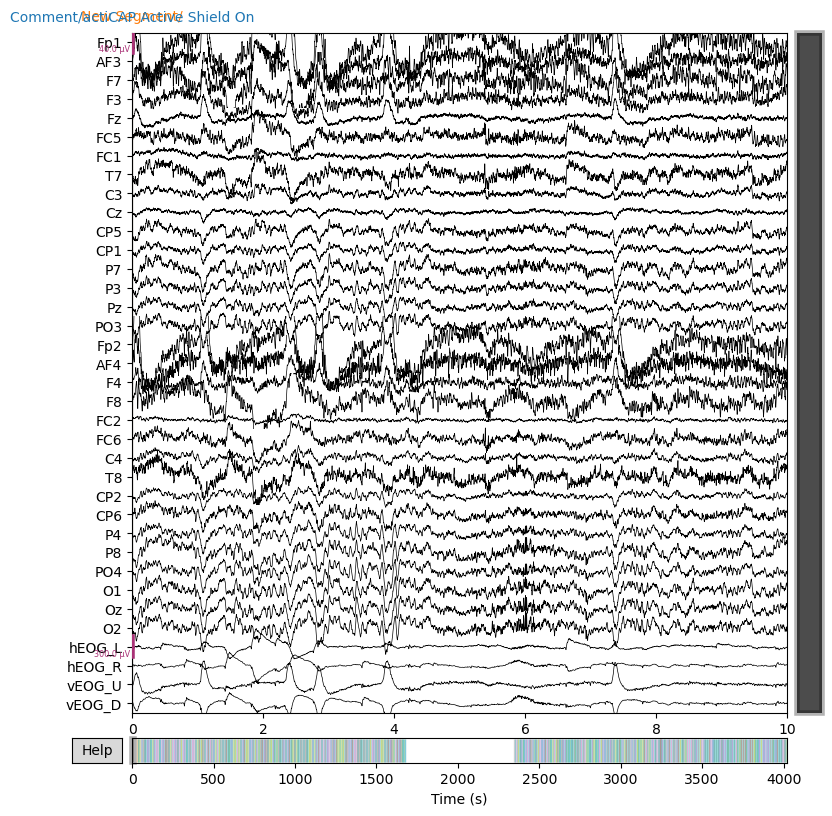

In [11]:
raw.plot(n_channels=36);

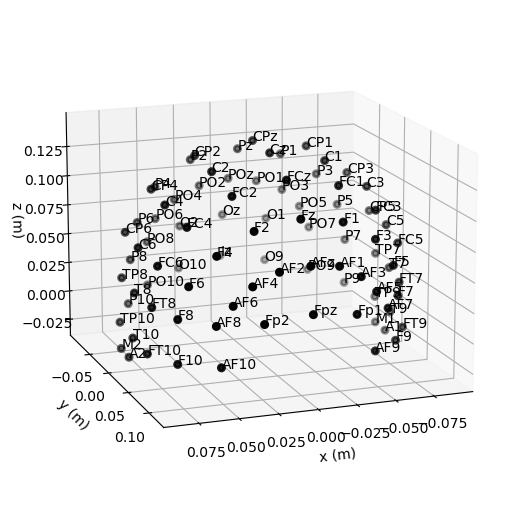

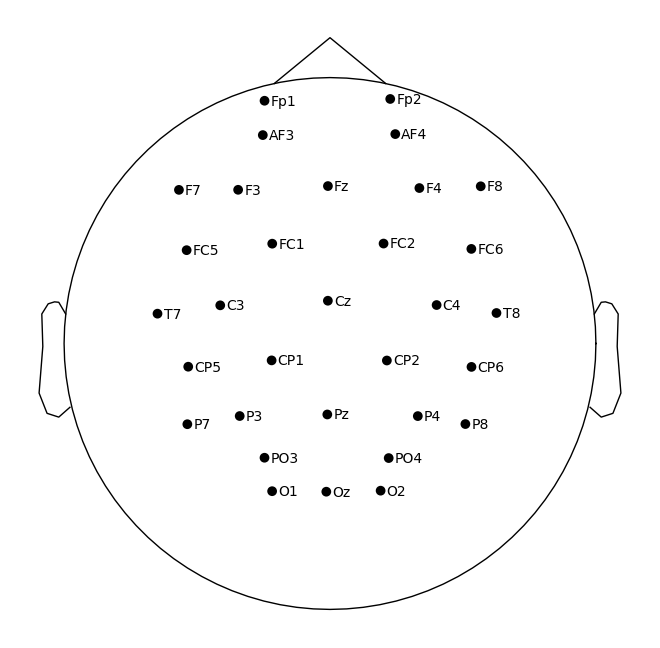

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


In [13]:
raw.plot_sensors(show_names=True,sphere=0.11);
fig = montage.plot(kind='3d',show=False)
fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial

### Plotting spectral density of continuous data

- To visualize the frequency content of continuous data

- the Raw object provides a compute_psd() method to compute spectral density and the resulting Spectrum object has a plot() method

Effective window size : 0.102 (s)


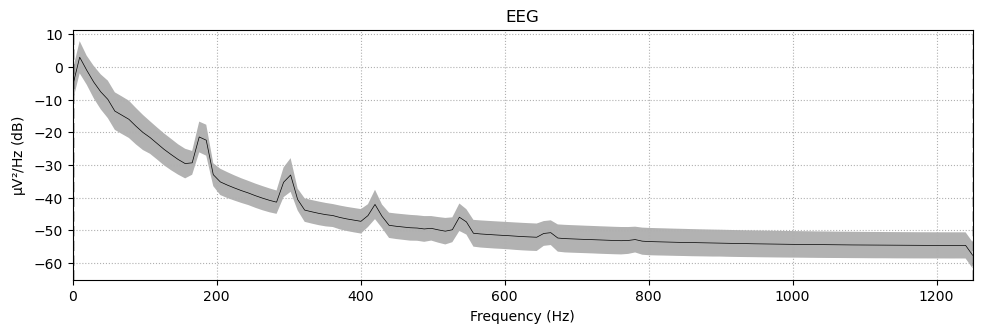

In [11]:
spectrum = raw.compute_psd()
spectrum.plot(average=True)

### plot spectral power estimates across sensors as a scalp topography
- will compute power based on magnetometer channels (if present), and will plot the power estimates on a dB-like log-scale.

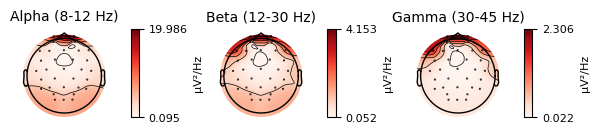

In [16]:
spectrum.plot_topomap(bands={'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),'Gamma (30-45 Hz)': (30,45)});

### plot the PSD for every sensor on its own axes
- the axes arranged spatially to correspond to sensor locations in space.

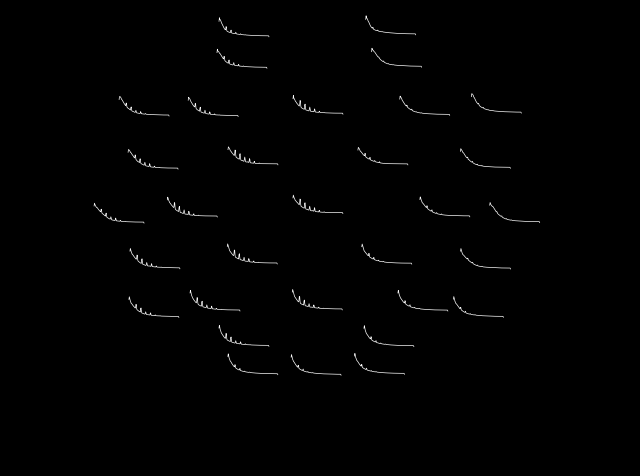

In [17]:
spectrum.plot_topo();

### Refrencing EEG

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


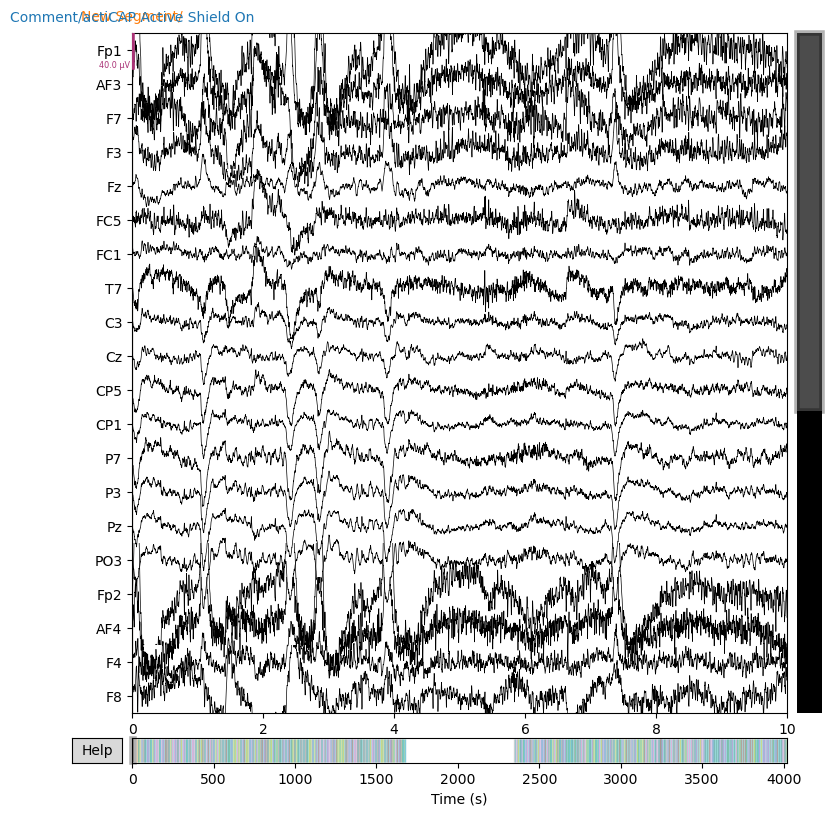

In [13]:
# Average reference. This is normally added by default, but can also be added
# explicitly.
raw.set_eeg_reference(ref_channels='average')
raw.plot();

In [3]:
# ### Detect Ocular artifacts (EOG)

# - MNE-Python includes functions for detecting and extracting ocular artifacts: find_eog_events() and create_eog_epochs(). Once again we’ll use the higher-level convenience function that automatically finds the artifacts and extracts them in to an Epochs object in one step. 

# - ocular artifacts are usually most prominent in the EEG channels.

# - note that there are many fewer blinks than heartbeats, which makes the image plots appear somewhat blocky.

In [26]:
# # baseline : The electrical signal from a sensor when no measured variable is present. Often referred to the output at no-load condition
# eog_epochs = mne.preprocessing.create_eog_epochs(raw,ch_name=["hEOG_L", "hEOG_R", "vEOG_U", "vEOG_D"], baseline=(-0.5, -0.2))
# eog_epochs.plot_image(combine='mean');
# eog_epochs.average().plot_joint();

In [1]:
# eog_epochs

In [4]:
# ### Repairing artifacts with regression --Raw Data--
# Remove EOG artifact signals from other channels by regression.

In [28]:
# weights = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(raw)

In [29]:
# fig = weights.plot(vlim=(None, 0.4))  # regression coefficients / weights as topomap
# fig.set_size_inches(3, 2)

In [30]:
# # Fit the regression model
# raw_clean = weights.apply(raw, copy=False)

# # Show the filter weights in a topomap
# weights.plot();

In [5]:
# ### Repairing artifacts with ICA
# Note : ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers

In [31]:
# ica = mne.preprocessing.ICA(n_components=32, max_iter='auto',random_state=0,method='infomax')
# ica.fit(raw.copy()) 

In [33]:
# ica.plot_components();

In [34]:
# # use automatic detection
# bad_indx,scores = ica.find_bads_eog(raw,ch_name=["hEOG_L","hEOG_R","vEOG_U","vEOG_D"],threshold=3,)
# print(bad_indx)

In [35]:
# raw.plot(n_channels=32);

In [36]:
# ica.exclude = bad_indx
# ica.apply(raw.copy(),exclude=ica.exclude).plot();

In [ ]:
# ica.apply(raw,exclude=ica.exclude)

### Read Events & Epoching

In [14]:
events = mne.events_from_annotations(raw)

Used Annotations descriptions: ['Comment/actiCAP Active Shield On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']


In [15]:
list(events[0])

[array([    0,     0, 99999]),
 array([    0,     0, 10001]),
 array([74444,     0,    13]),
 array([84522,     0,     1]),
 array([92039,     0,    11]),
 array([102086,      0,      8]),
 array([112162,      0,      6]),
 array([119674,      0,     61]),
 array([129717,      0,      8]),
 array([139803,      0,      4]),
 array([147313,      0,     41]),
 array([157360,      0,      8]),
 array([167434,      0,      3]),
 array([174944,      0,     31]),
 array([184986,      0,      8]),
 array([195071,      0,      1]),
 array([202582,      0,     11]),
 array([212626,      0,      8]),
 array([222696,      0,      2]),
 array([230206,      0,     21]),
 array([240248,      0,      8]),
 array([250323,      0,      2]),
 array([257833,      0,     21]),
 array([267875,      0,      8]),
 array([277950,      0,      1]),
 array([285460,      0,     11]),
 array([295502,      0,      8]),
 array([305580,      0,      6]),
 array([313090,      0,     61]),
 array([323132,      0,      

In [16]:
event_ids = {'Stimulus/S 11': 11,'Stimulus/S 21': 21,'Stimulus/S 31': 31,'Stimulus/S 41': 41,'Stimulus/S 51': 51,'Stimulus/S 61': 61, 'Stimulus/S 8': 8}
epochs = mne.Epochs(raw, events=events[0], event_id=event_ids, tmin=0, tmax=4, preload=True,baseline=(0, 0))
epochs

Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 600 events and 10001 original time points ...
0 bad epochs dropped


Number of events,600
Events,Stimulus/S 11: 50Stimulus/S 21: 50Stimulus/S 31: 50Stimulus/S 41: 50Stimulus/S 51: 50Stimulus/S 61: 50Stimulus/S 8: 300
Time range,0.000 – 4.000 sec
Baseline,0.000 – 0.000 sec


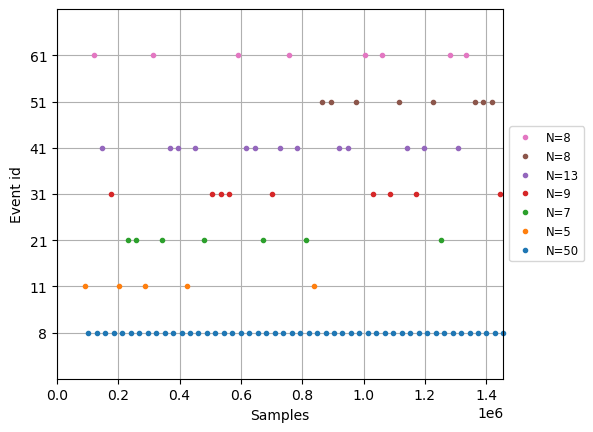

In [17]:
mne.viz.plot_events(epochs.events[:100]);

In [18]:
epochs.get_data().shape

(600, 36, 10001)

In [19]:
epoch_11 = epochs['Stimulus/S 11'][0].average()
epoch_21 = epochs['Stimulus/S 21'][0].average()
epoch_31 = epochs['Stimulus/S 31'][0].average()
epoch_41 = epochs['Stimulus/S 41'][0].average()
epoch_51 = epochs['Stimulus/S 51'][0].average()
epoch_61 = epochs['Stimulus/S 61'][0].average()
epoch_8 = epochs['Stimulus/S 8'][0].average()

combining channels using "gfp"
combining channels using "gfp"


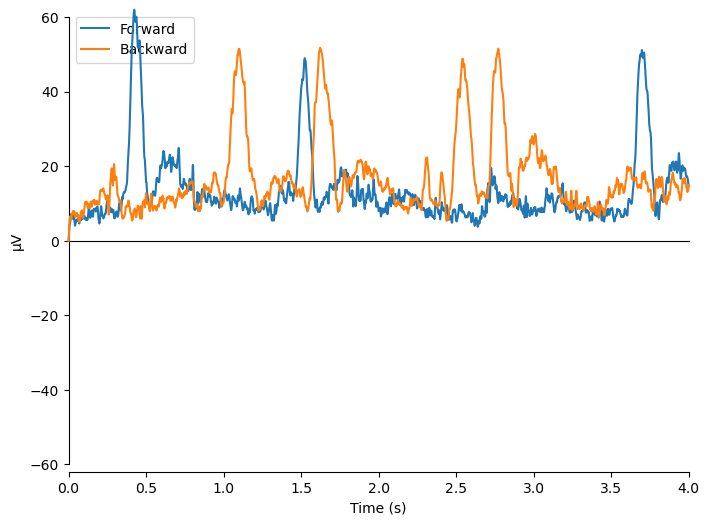

combining channels using "gfp"
combining channels using "gfp"


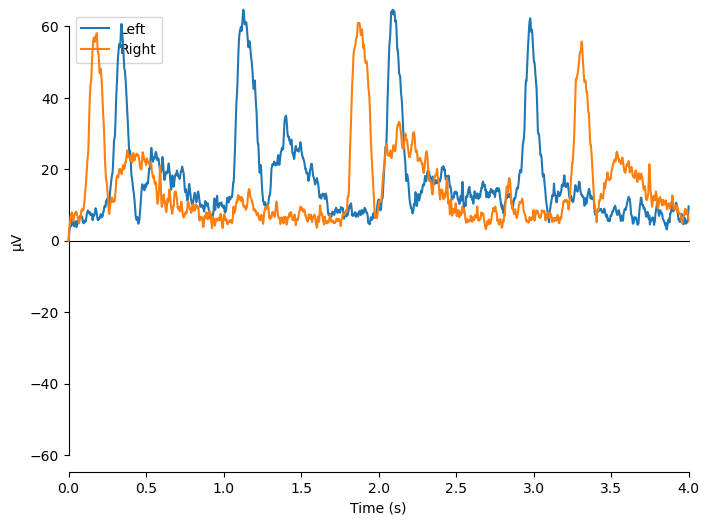

combining channels using "gfp"
combining channels using "gfp"


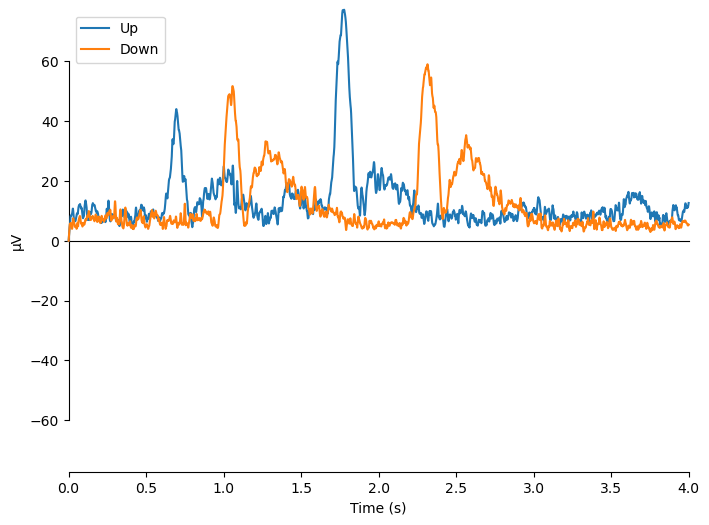

[<Figure size 800x600 with 1 Axes>]

In [20]:
decode = {11: 'Forward', 21: 'Backward', 31: 'Left', 41: 'Right', 51: 'Up', 61: 'Down', 8 : 'Rest'}
mne.viz.plot_compare_evokeds({decode[11]: epoch_11, decode[21]: epoch_21})
mne.viz.plot_compare_evokeds({decode[31]: epoch_31, decode[41]: epoch_41})
mne.viz.plot_compare_evokeds({decode[51]: epoch_51, decode[61]: epoch_61})

### Epochs Downsampling 

In [21]:
epochs.resample(sfreq=1250)
epochs.get_data().shape

(600, 36, 5000)

In [40]:
# epochs.plot(n_epochs=5);

### Repairing artifacts with ICA 
Note : ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers

In [25]:
# ica = mne.preprocessing.ICA(n_components=20, max_iter='auto',random_state=0,method='fastica')
# ica.fit(epochs.copy()) 

In [33]:
# ica.plot_components();

In [34]:
# # use automatic detection
# bad_indx,scores = ica.find_bads_eog(raw,ch_name=["hEOG_L","hEOG_R","vEOG_U","vEOG_D"],threshold=2)
# print(bad_indx)

In [35]:
# epochs.plot(n_epochs=5);

In [36]:
# ica.exclude = bad_indx
# ica.apply(epochs.copy(),exclude=ica.exclude).plot(n_epochs=5);

In [37]:
# ica.apply(epochs,exclude=ica.exclude)

### Repairing artifacts with regression 
Remove EOG artifact signals from other channels by regression.

In [66]:
# # plotting before
# # plot the evoked for the EEG and the EOG sensors
# fig = epochs.average('all').plot()
# fig.set_size_inches(6, 6)

In [67]:
# # Perform regression using the EOG sensor as independent variable and the EEG
# # sensors as dependent variables.
# model_plain = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(epochs)
# fig = model_plain.plot(vlim=(None, 0.4))  # regression coefficients as topomap
# fig.set_size_inches(3, 2);

In [68]:
# epochs_clean_plain = model_plain.apply(epochs)
# # After regression, we should redo the baseline correction
# epochs_clean_plain.apply_baseline(baseline=(3, 7))
# # Show the evoked potential computed on the corrected data
# fig = epochs_clean_plain.average('all').plot()
# fig.set_size_inches(6, 6)

In [69]:
# # create epochs with the evoked subtracted out
# epochs_sub = epochs.copy().subtract_evoked()

# # perform regression
# model_sub = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(epochs_sub)
# fig = model_sub.plot(vlim=(None, 0.4))
# fig.set_size_inches(3, 2)

# # apply the regression coefficients to the original epochs
# epochs_clean_sub = model_plain.apply(epochs).apply_baseline(baseline=(3, 7))
# fig = epochs_clean_sub.average('all').plot()
# fig.set_size_inches(6, 6)

In [70]:
# eog_epochs = mne.preprocessing.create_eog_epochs(raw)
# # We need to explicitly specify that we want to average the EOG channel too.
# eog_evoked = eog_epochs.average('all')
# eog_evoked.plot('all')
# fig.set_size_inches(6, 6)

# # perform regression on the evoked blink response
# model_evoked = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(eog_evoked)
# fig = model_evoked.plot(vlim=(None, 0.4))
# fig.set_size_inches(3, 2)

# # apply the regression coefficients to the original epochs
# epochs_clean_evoked = model_evoked.apply(epochs).apply_baseline(baseline=(3, 7))
# fig = epochs_clean_evoked.average('all').plot()
# fig.set_size_inches(6, 6)

# # for good measure, also show the effect on the blink evoked
# eog_evoked_clean = model_evoked.apply(eog_evoked)
# eog_evoked_clean.apply_baseline(baseline=(0, 0))
# eog_evoked_clean.plot('all')
# fig.set_size_inches(6, 6)

In [71]:
# order = np.concatenate([  # plotting order: EOG first, then EEG
#     mne.pick_types(raw.info, meg=False, eog=True),
#     mne.pick_types(raw.info, meg=False, eeg=True),
# ])
# raw_kwargs = dict(events=eog_epochs.events, order=order, start=13, duration=3,
#                   n_channels=10, scalings=dict(eeg=50e-6, eog=250e-6))

# # plot original data
# raw.plot(**raw_kwargs);

# # regress (using coefficients computed previously) and plot
# raw_clean = model_evoked.apply(raw)
# raw_clean.plot(**raw_kwargs);

In [40]:
# epochs.apply_baseline((None,0))

In [41]:
# epochs["Stimulus/S 41"].plot_image(picks=[5]); # picks=[channel index]

In [ ]:
# epochs.equalize_event_counts(event_ids)
# epochs

### DWT

In [26]:
import pywt
from pywt import wavedec
coeffs = wavedec(epochs, 'db4' , level=6)
len(coeffs)

7

In [27]:
coeffs = np.array(coeffs[6])
coeffs.shape

(600, 36, 2503)

In [90]:
# # Compute statistical features from DWT coefficients
# mean_coeffs = [np.mean(c) for c in coeffs]
# std_coeffs = [np.std(c) for c in coeffs]
# max_coeffs = [np.max(np.abs(c)) for c in coeffs]
# min_coeffs = [np.min(np.abs(c)) for c in coeffs]

# # Print results
# print("Mean coefficients:", len(mean_coeffs))
# print("Standard deviation of coefficients:", len(std_coeffs))
# print("Maximum absolute value of coefficients:", len(max_coeffs))
# print("Minimum absolute value of coefficients:", len(min_coeffs))

In [28]:
# Extract statistical features from each frequency band
features = np.empty(shape=(600,5))
for i in range(len(coeffs)):
    band_features = [np.mean(coeffs[i]), np.var(coeffs[i]), 
                     np.std(coeffs[i]), np.max(coeffs[i]), np.min(coeffs[i])]
    features[i] = band_features
print(features.shape)

(600, 5)


In [29]:
# Compute entropy features from the output of DWT
entropy_features = []
for coeff in coeffs:
    # Calculate energy of coefficients
    energy = np.sum(coeff ** 2)
    
    # Normalize coefficients by their energy
    norm_coeff = coeff / np.sqrt(energy)
    
    # Calculate entropy of normalized coefficients
    entropy = -np.sum(norm_coeff ** 2 * np.log2(norm_coeff ** 2))
    
    # Add entropy feature to list
    entropy_features.append(entropy)

print('Entropy features:', len(entropy_features))

Entropy features: 600


In [30]:
feature_vectors = np.empty(shape=(600,6))
for i in range(len(features)):
    feature_vectors[i][:5] = features[i]
    feature_vectors[i][5] = entropy_features[i]
feature_vectors.shape

(600, 6)

In [127]:
# # Combine statistical features into feature vector for each EEG signal
# feature_vectors = []
# for eeg_signal in data:
#     coeffs = pywt.wavedec(eeg_signal, 'db4', level=7)
#     eeg_features = []
#     for i in range(len(coeffs)):
#         band_features = [np.mean(coeffs[i]), np.var(coeffs[i]), 
#                          np.std(coeffs[i]), np.max(coeffs[i]), np.min(coeffs[i])]
#         eeg_features += band_features
#     feature_vectors.append(eeg_features)

In [39]:
data = np.array(feature_vectors)
data.shape

(600, 6)

In [32]:
labels = np.empty(shape=(600))
decode = {11: 0, 21: 1, 31: 2, 41:3, 51: 4, 61: 5, 8 :6}
k=0
for i in epochs.events:
    labels[k]=decode[i[2]]
    k+=1

In [33]:
data.shape

(600, 6)

In [34]:
labels.shape

(600,)

In [54]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2,stratify=labels,shuffle=True)

In [83]:
# ind = np.argsort(y_train)
# y_train = y_train[ind]
# X_train = X_train[ind]

In [84]:
# ind = np.argsort(y_val)
# y_val = y_val[ind]
# X_val = X_val[ind]

In [48]:
# y_train=tf.keras.utils.to_categorical(y_train,num_classes=7) 
# y_val=tf.keras.utils.to_categorical(y_val,num_classes=7) 

In [120]:
# Normaliation
# X_train = MinMaxScaler().fit_transform(X_train)
# X_val = MinMaxScaler().fit_transform(X_val)
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_val = (X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val))

In [90]:
# def preprocess_input(eeg_signals):
#     eeg_signals_3d = np.zeros((eeg_signals.shape[0], 32, 2500, 3))
#     for i in range(eeg_signals.shape[0]):
#         trial_3d = np.dstack([eeg_signals[0],eeg_signals[0],eeg_signals[0]])
#         eeg_signals_3d[i] = trial_3d
#     return eeg_signals_3d
# X_train = preprocess_input(X_train)
# X_val = preprocess_input(X_val)

In [55]:
print('X_train: ',X_train.shape)
print('X_val:   ',X_val.shape)
print('y_train: ',y_train.shape)
print('y_val:   ',y_val.shape)

X_train:  (480, 6)
X_val:    (120, 6)
y_train:  (480,)
y_val:    (120,)


## ML

In [42]:
# ‘svd’, ‘lsqr’, ‘eigen’
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train, y_train)

evaluate_train=[X_train, y_train]
evaluate_test=[X_val, y_val]

# model accuracy for svc model

train_accuracy = lda.score(*evaluate_train)
test_accuracy = lda.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  0.5
test accuracy:   0.49166666666666664


In [47]:
# training a linear SVM classifier
from sklearn import svm

# linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
model = svm.SVC(kernel='linear', degree=20, C=2).fit(X_train, y_train)

evaluate_train=[X_train, y_train]
evaluate_test=[X_val, y_val]

# model accuracy for svc model

train_accuracy = model.score(*evaluate_train)
test_accuracy = model.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  0.5
test accuracy:   0.5


## MLP

In [60]:
# Import MLPClassifer 
from sklearn.neural_network import MLPClassifier

# Create model object
clf = MLPClassifier(hidden_layer_sizes=(100, 50),
                    random_state=10,
                    verbose=True,
                    max_iter=50,
                    learning_rate_init=0.1)

# Fit data onto the model
clf.fit(X_train,y_train)

Iteration 1, loss = 7.11280841
Iteration 2, loss = 1.90469253
Iteration 3, loss = 1.69000081
Iteration 4, loss = 1.61972368
Iteration 5, loss = 1.62294877
Iteration 6, loss = 1.60399737
Iteration 7, loss = 1.59345438
Iteration 8, loss = 1.59930807
Iteration 9, loss = 1.59087758
Iteration 10, loss = 1.59084711
Iteration 11, loss = 1.59254926
Iteration 12, loss = 1.59398635
Iteration 13, loss = 1.59150582
Iteration 14, loss = 1.59008791
Iteration 15, loss = 1.59361402
Iteration 16, loss = 1.59092117
Iteration 17, loss = 1.59151720
Iteration 18, loss = 1.59204354
Iteration 19, loss = 1.59229797
Iteration 20, loss = 1.59280838
Iteration 21, loss = 1.59031891
Iteration 22, loss = 1.59213275
Iteration 23, loss = 1.59343461
Iteration 24, loss = 1.59101870
Iteration 25, loss = 1.59205312
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(hidden_layer_sizes=(100, 50), learning_rate_init=0.1, max_iter=50,
              random_state=10, verbose=True)

In [62]:
# Make prediction on test dataset
ypred=clf.predict(X_val)

# Import accuracy score 
from sklearn.metrics import accuracy_score

# Calcuate accuracy
accuracy_score(y_val,ypred)

0.5